<H1><center>SEAS 8515 Data Engineering - Project 4</center></H1>
<H2><center>Loans Dataset</center></H2>
<H3><center>Juan Falck, May 2024</center></H3>

# Load required libaries

In [0]:
from __future__ import print_function

from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression
#from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
#from xgboost.spark import SparkXGBRegressor

import numpy as np
import pandas as pd


In [0]:
#spark = SparkSession.builder.appName("Project4_loans").getOrCreate()

# Increase JVM heap space
#spark = SparkSession.builder \
#    .appName("Project4") \
#    .config("spark.driver.memory", "6g") \
#    .config("spark.executor.memory", "6g") \
#    .getOrCreate()



# Read in raw dataset

In [0]:
data_path = "dbfs:/FileStore/myfiles/loan_data_project4.csv"

df = spark.read.option("header", "true") \
                 .option("inferSchema", "true") \
                 .csv(data_path)

df.show()

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-

# Review dataset

In [0]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

In [0]:
num_rows = df.count()
print(f"Number of rows: {num_rows}")

num_columns = len(df.columns)
print(f"Number of columns: {num_columns}")


Number of rows: 2260701
Number of columns: 151


In [0]:
from pyspark.sql.functions import col, median, when, isnan, mean
# Convert string columns to numerical
filtered_df = df

# List of columns to be converted to numerical types (assuming you have identified them)
numerical_columns = ["annual_inc","dti","delinq_2yrs","fico_range_low","fico_range_high","inq_last_6mths",
                    "open_acc", "pub_rec","revol_bal","revol_util","total_acc","out_prncp","out_prncp_inv",
                    "total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee",
                    "recoveries","collection_recovery_fee","last_pymnt_amnt","last_fico_range_high","last_fico_range_low",
                    "collections_12_mths_ex_med","acc_now_delinq","tot_coll_amt","tot_cur_bal","open_acc_6m","open_act_il",
                    "open_il_12m","open_il_24m","mths_since_rcnt_il","total_bal_il","il_util","open_rv_12m","open_rv_24m",
                    "max_bal_bc","all_util","total_rev_hi_lim","inq_fi","total_cu_tl","avg_cur_bal","bc_util"] 


# Convert columns to numerical types
for column in numerical_columns:
    filtered_df = filtered_df.withColumn(column, col(column).cast("double"))

filtered_df.printSchema()


root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: double 

In [0]:
filtered_df.show()

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-

## Review categorical features

In [0]:
# List of string type columns to be analyzed
string_columns = ["grade","sub_grade","home_ownership","verification_status","loan_status","pymnt_plan",
                 "purpose","initial_list_status","application_type","hardship_flag"]
# Create a temporary view of the DataFrame
filtered_df.createOrReplaceTempView("filtered_data")

# Loop through each string column and show group by count using Spark SQL
for column in string_columns:
    query = f"""
    SELECT {column}, COUNT(*) AS count
    FROM filtered_data
    GROUP BY {column}
    ORDER BY count DESC
    """
    print(f"Group by count for column: {column}")
    spark.sql(query).show(truncate=False)


Group by count for column: grade
+-----+------+
|grade|count |
+-----+------+
|B    |663557|
|C    |650053|
|A    |433027|
|D    |324424|
|E    |135639|
|F    |41800 |
|G    |12168 |
|NULL |33    |
+-----+------+

Group by count for column: sub_grade
+---------+------+
|sub_grade|count |
+---------+------+
|C1       |145903|
|B5       |140288|
|B4       |139793|
|B3       |131514|
|C2       |131116|
|C3       |129193|
|C4       |127115|
|B2       |126621|
|B1       |125341|
|C5       |116726|
|A5       |107617|
|A4       |95874 |
|A1       |86790 |
|D1       |81787 |
|A3       |73184 |
|D2       |72899 |
|A2       |69562 |
|D3       |64819 |
|D4       |56896 |
|D5       |48023 |
+---------+------+
only showing top 20 rows

Group by count for column: home_ownership
+--------------+-------+
|home_ownership|count  |
+--------------+-------+
|MORTGAGE      |1111449|
|RENT          |894929 |
|OWN           |253057 |
|ANY           |996    |
|OTHER         |182    |
|NONE          |54     |


## Data cleaning

In [0]:
# List of string type columns to be removed
columns_to_remove = ["id","application_type","initial_list_status","purpose","emp_title","desc","title","policy_code"]

# Remove the specified columns from the DataFrame
filtered_df = filtered_df.drop(*columns_to_remove)

# Verify the schema to ensure columns are removed
filtered_df.printSchema()


root
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- fico_range_low: double (nullable = true)
 |-- fico_range_high: double (nu

In [0]:
#from prettytable import PrettyTable
# Set Pandas display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust display width to show all columns

# Select the top 5 rows
top_5_rows = filtered_df.limit(25)

# Convert the selected rows to a Pandas DataFrame
top_5_rows_pd = top_5_rows.toPandas()
top_5_rows_pd.head(10)


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,None,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,None,7.0,0.0,2765.0,29.7,13.0,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,None,Mar-2019,564.0,560.0,0.0,30.0,None,None,None,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Cash,N,None,None,None,None,None,None
1,None,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,None,22.0,0.0,21470.0,19.2,38.0,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,None,Mar-2019,699.0,695.0,0.0,None,None,None,None,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Cash,N,None,None,None,None,None,None
2,None,20000.0,20000.0,20000.0,60 months,10.7

# Question 1 - Statistical significant relationship between FICO and Int Rate

In [0]:
#from pyspark.sql import SparkSession
#from pyspark.sql.functions import col, median, when, isnan, mean
from pyspark.sql import functions as F
#import pandas as pd
#import numpy as np
from scipy.stats import pearsonr

# Impute missing values with median
median_fico = filtered_df.select(F.expr('percentile_approx(fico_range_high, 0.5)').alias('median')).collect()[0][0]
median_int_rate = filtered_df.select(F.expr('percentile_approx(int_rate, 0.5)').alias('median')).collect()[0][0]

filtered_df = filtered_df.withColumn("fico_range_high", when(col("fico_range_high").isNull(), median_fico).otherwise(col("fico_range_high")))
filtered_df = filtered_df.withColumn("int_rate", when(col("int_rate").isNull(), median_int_rate).otherwise(col("int_rate")))

# Calculate correlation
corr = filtered_df.corr("fico_range_high", "int_rate")

# Convert to Pandas for statistical test
pd_df = filtered_df.select("fico_range_high", "int_rate").toPandas()

# Perform Pearson correlation test
pearson_corr, p_value = pearsonr(pd_df['fico_range_high'], pd_df['int_rate'])

corr, pearson_corr, p_value


(-0.4133276723376603, -0.4133276723376553, 0.0)

# Question 2 - Can we cluster customers using loan data for Market Segementation Campaigns

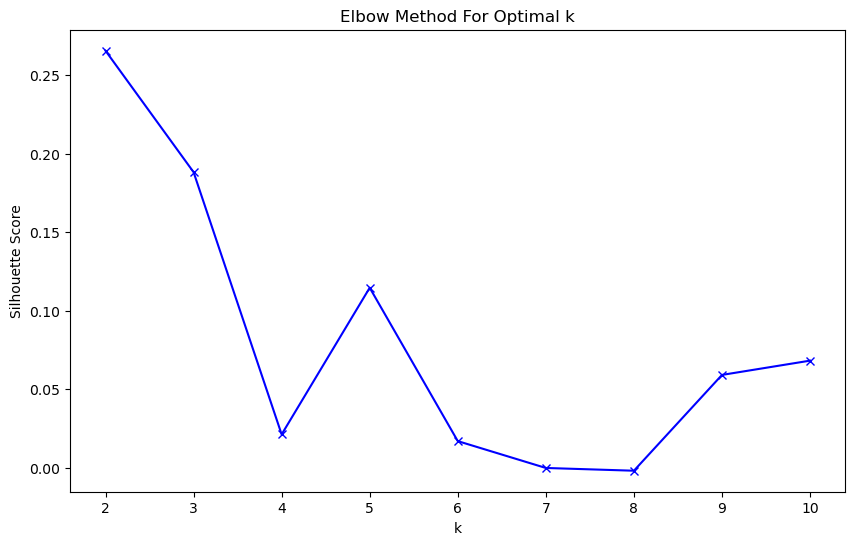

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Impute missing values with median for all numerical columns
numerical_cols = [col for col, dtype in filtered_df.dtypes if dtype in ('int', 'double')]
median_values = filtered_df.select([F.expr(f'percentile_approx({col}, 0.5)').alias(col) for col in numerical_cols]).collect()[0]

imputed_df = filtered_df
for col, median_value in zip(numerical_cols, median_values):
    imputed_df = imputed_df.withColumn(col, F.when(F.col(col).isNull(), median_value).otherwise(F.col(col)))

# Assemble numerical features into a single feature vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
assembled_df = assembler.transform(imputed_df)

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

# Elbow method to find the optimal number of clusters
k_values = list(range(2, 11))
silhouette_scores = []

evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", metricName="silhouette", distanceMeasure="squaredEuclidean")

for k in k_values:
    kmeans = KMeans(k=k, seed=1, featuresCol="scaledFeatures")
    model = kmeans.fit(scaled_df)
    predictions = model.transform(scaled_df)
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

# Plot the elbow method result
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Elbow Method For Optimal k')
plt.show()


# Question 3 - Can we use dimensioniality reduction (PCA) tehcnique to display the customer segmentation clusters found using K-Means

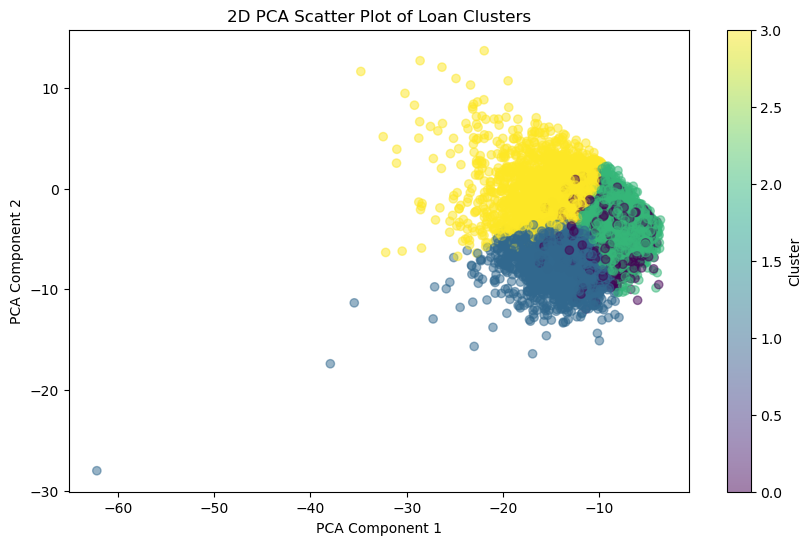

In [0]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
#from pyspark.ml.clustering import KMeans
#from pyspark.ml.evaluation import ClusteringEvaluator
#import matplotlib.pyplot as plt


# Cluster the data with k=4
k = 4
kmeans = KMeans(k=k, seed=1, featuresCol="scaledFeatures")
model = kmeans.fit(scaled_df)
clustered_df = model.transform(scaled_df).withColumnRenamed("prediction", "cluster")

# Sample 1% of the data
sampled_df = clustered_df.sample(withReplacement=False, fraction=0.01, seed=1)

# Apply PCA to reduce dimensions to 2D
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(sampled_df)
pca_df = pca_model.transform(sampled_df)

# Convert to Pandas DataFrame for plotting
pandas_df = pca_df.select("pcaFeatures", "cluster").toPandas()
pandas_df['pca1'] = pandas_df['pcaFeatures'].apply(lambda x: x[0])
pandas_df['pca2'] = pandas_df['pcaFeatures'].apply(lambda x: x[1])

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['pca1'], pandas_df['pca2'], c=pandas_df['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Scatter Plot of Loan Clusters')
plt.colorbar(label='Cluster')
plt.show()


# Loan Approval prediction model

In [0]:
from pyspark.sql.functions import col, when

# List of columns to select
columns_to_select = ["loan_amnt","home_ownership","annual_inc","verification_status","loan_status","dti",
                    "delinq_2yrs","fico_range_low","inq_last_6mths","open_acc","pub_rec","revol_bal","revol_util",
                     "total_acc","acc_now_delinq","tot_coll_amt","max_bal_bc","bc_util","mort_acc","num_accts_ever_120_pd",
                     "pub_rec_bankruptcies","tax_liens","hardship_flag"]

# Create a new DataFrame with selected columns
selected_df = filtered_df.select(columns_to_select)

# Exclude specific loan statuses and create the target column
selected_df = selected_df.filter(~col("loan_status").isin("In Grace Period", "Oct-2015", "null"))
selected_df = selected_df.withColumn("target", when(col("loan_status").isin(
    "Charged Off", "Late (31-120 days)", "Does not meet the credit policy. Status:Charged Off", "Default"), 1).otherwise(0))

# Drop the original loan_status column
selected_df = selected_df.drop("loan_status")

selected_df.show(5)


+---------+--------------+----------+-------------------+-----+-----------+--------------+--------------+--------+-------+---------+----------+---------+--------------+------------+----------+-------+--------+---------------------+--------------------+---------+-------------+------+
|loan_amnt|home_ownership|annual_inc|verification_status|  dti|delinq_2yrs|fico_range_low|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|acc_now_delinq|tot_coll_amt|max_bal_bc|bc_util|mort_acc|num_accts_ever_120_pd|pub_rec_bankruptcies|tax_liens|hardship_flag|target|
+---------+--------------+----------+-------------------+-----+-----------+--------------+--------------+--------+-------+---------+----------+---------+--------------+------------+----------+-------+--------+---------------------+--------------------+---------+-------------+------+
|   3600.0|      MORTGAGE|   55000.0|       Not Verified| 5.91|        0.0|         675.0|           1.0|     7.0|    0.0|   2765.0|      29.7|     

In [0]:
# Select the top 5 rows
top_5_rows = selected_df.limit(20)

# Convert the selected rows to a Pandas DataFrame
top_5_rows_pd = top_5_rows.toPandas()
top_5_rows_pd.head(5)


,loan_amnt,home_ownership,annual_inc,verification_status,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,tot_coll_amt,max_bal_bc,bc_util,mort_acc,num_accts_ever_120_pd,pub_rec_bankruptcies,tax_liens,hardship_flag,target
0,3600.0,MORTGAGE,55000.0,Not Verified,5.91,0.0,675.0,1.0,7.0,0.0,2765.0,29.7,13.0,0.0,722.0,722.0,37.2,1.0,2.0,0.0,0.0,N,0
1,24700.0,MORTGAGE,65000.0,Not Verified,16.06,1.0,715.0,4.0,22.0,0.0,21470.0,19.2,38.0,0.0,0.0,6472.0,27.1,4.0,0.0,0.0,0.0,N,0
2,20000.0,MORTGAGE,63000.0,Not Verified,10.78,0.0,695.0,0.0,6.0,0.0,7869.0,56.2,18.0,0.0,0.0,2081.0,55.9,5.0,0.0,0.0,0.0,N,0
3,35000.0,MORTGAGE,110000.0,Source Verified,17.06,0.0,785.0,0.0,13.0,0.0,7802.0,11.6,17.0,0.0,0.0,6987.0,12.1,1.0,0.0,0.0,0.0,N,0
4,10400.0,MORTGAGE,104433.0,Source Verified,25.37,1.0,695.0,3.0,12.0,0.0,21929.0,64.5,35.0,0.0,0.0,9702.0,77.5,6.0,0.0,0.0,0.0,N,0


In [0]:
# Separate the majority and minority classes
minority_class_df = selected_df.filter(col("target") == 1)
majority_class_df = selected_df.filter(col("target") == 0)

# Count the number of rows in each class
minority_class_count = minority_class_df.count()
majority_class_count = majority_class_df.count()

print(f"Minority class count: {minority_class_count}")
print(f"Majority class count: {majority_class_count}")


Minority class count: 290826
Majority class count: 1961405


In [0]:
# Calculate the fraction to sample the majority class
fraction = minority_class_count / float(majority_class_count)

# Undersample the majority class
undersampled_majority_class_df = majority_class_df.sample(withReplacement=False, fraction=fraction, seed=42)

# Count the number of rows in the undersampled majority class
undersampled_majority_class_count = undersampled_majority_class_df.count()
print(f"Undersampled majority class count: {undersampled_majority_class_count}")



Undersampled majority class count: 291124


In [0]:
# Combine the undersampled majority class with the minority class
balanced_df = minority_class_df.union(undersampled_majority_class_df)

# Count the number of rows in the balanced dataset
balanced_count = balanced_df.count()
print(f"Balanced dataset count: {balanced_count}")


Balanced dataset count: 581950


In [0]:
# Extract subset of the dataset
balanced_df = balanced_df.sample(withReplacement=False, fraction=0.002, seed=88)

# Count the number of rows in the subset to confirm
subset_count = balanced_df.count()
print(f"Subset dataset count: {subset_count}")


Subset dataset count: 1182


# ModelTraining and MFLOW Utilization

In [0]:
#from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, DoubleType, IntegerType
from pyspark.sql.functions import col, count, desc
from pyspark.ml.feature import StringIndexer, VectorAssembler, Imputer
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
import mlflow
import mlflow.spark


# Fill NA's in string columns with the most frequent value
string_cols = [field.name for field in balanced_df.schema.fields if isinstance(field.dataType, StringType)]

for col_name in string_cols:
    # Calculate mode for the column
    mode_row = balanced_df.groupBy(col_name).count().orderBy(desc("count")).first()
    if mode_row:
        mode = mode_row[0]
        if mode is not None:
            print(f"Filling NA values in column {col_name} with mode: {mode}")
            balanced_df = balanced_df.na.fill({col_name: mode})
        else:
            print(f"No valid mode found for column {col_name}. Skipping NA fill for this column.")
    else:
        print(f"No rows found for column {col_name}. Skipping NA fill for this column.")


# Split data into training and test sets
train_df, test_df = balanced_df.randomSplit([0.8, 0.2], seed=12345)

# Impute numerical columns using median
num_cols = [field.name for field in balanced_df.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType)) and field.name != 'target']
imputer = Imputer(inputCols=num_cols, outputCols=num_cols).setStrategy("median")

# Index string columns with handleInvalid to skip or keep invalid entries
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in string_cols]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=[col + "_index" for col in string_cols] + num_cols, outputCol="features")

# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="target")

# Support Vector Machine (SVM)
svm = LinearSVC(featuresCol="features", labelCol="target")

# Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="target")

# Create pipelines
pipeline_lr = Pipeline(stages=[imputer] + indexers + [assembler, lr])
pipeline_svm = Pipeline(stages=[imputer] + indexers + [assembler, svm])
pipeline_rf = Pipeline(stages=[imputer] + indexers + [assembler, rf])

# Hyperparameter tuning for Logistic Regression
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .build()

# Hyperparameter tuning for SVM
paramGrid_svm = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1]) \
    .build()

# Hyperparameter tuning for Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20]) \
    .addGrid(rf.maxDepth, [5]) \
    .build()

# TrainValidationSplit for Logistic Regression
tvs_lr = TrainValidationSplit(estimator=pipeline_lr,
                              estimatorParamMaps=paramGrid_lr,
                              evaluator=BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction", metricName="areaUnderROC"),
                              trainRatio=0.8)

# TrainValidationSplit for SVM
tvs_svm = TrainValidationSplit(estimator=pipeline_svm,
                               estimatorParamMaps=paramGrid_svm,
                               evaluator=BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction", metricName="areaUnderROC"),
                               trainRatio=0.8)

# TrainValidationSplit for Random Forest
tvs_rf = TrainValidationSplit(estimator=pipeline_rf,
                              estimatorParamMaps=paramGrid_rf,
                              evaluator=BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction", metricName="areaUnderROC"),
                              trainRatio=0.8)

# Fit models and log with MLflow
with mlflow.start_run(run_name="logistic_regression") as run:
    model_lr = tvs_lr.fit(train_df)
    predictions_lr = model_lr.transform(test_df)
    accuracy_lr = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(predictions_lr)
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_metric("accuracy", accuracy_lr)
    mlflow.spark.log_model(model_lr, "model")

with mlflow.start_run(run_name="svm") as run:
    model_svm = tvs_svm.fit(train_df)
    predictions_svm = model_svm.transform(test_df)
    accuracy_svm = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(predictions_svm)
    mlflow.log_param("model_type", "SVM")
    mlflow.log_metric("accuracy", accuracy_svm)
    mlflow.spark.log_model(model_svm, "model")

with mlflow.start_run(run_name="random_forest") as run:
    model_rf = tvs_rf.fit(train_df)
    predictions_rf = model_rf.transform(test_df)
    accuracy_rf = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="rawPrediction", metricName="areaUnderROC").evaluate(predictions_rf)
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_metric("accuracy", accuracy_rf)
    mlflow.spark.log_model(model_rf, "model")

print(f"Logistic Regression Model accuracy: {accuracy_lr}")
print(f"SVM Model accuracy: {accuracy_svm}")
print(f"Random Forest Model accuracy: {accuracy_rf}")


Filling NA values in column home_ownership with mode: RENT
Filling NA values in column verification_status with mode: Source Verified
Filling NA values in column hardship_flag with mode: N


2024/05/31 11:32:38 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2024/05/31 11:33:21 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/158866598296923/0b7d3a942c984d538eefc07315067930/artifacts/model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 
/databricks/python/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# MFLOW Output

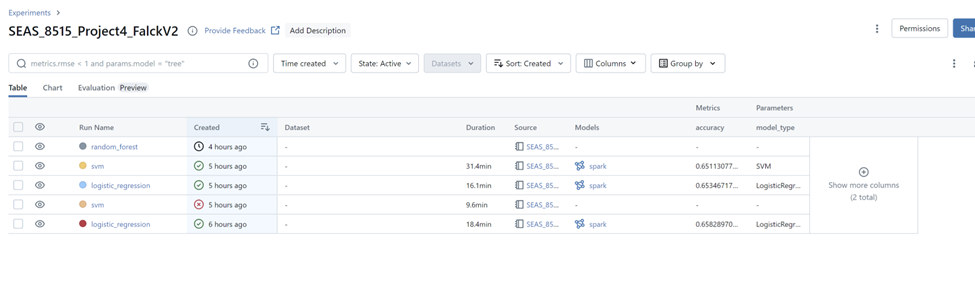

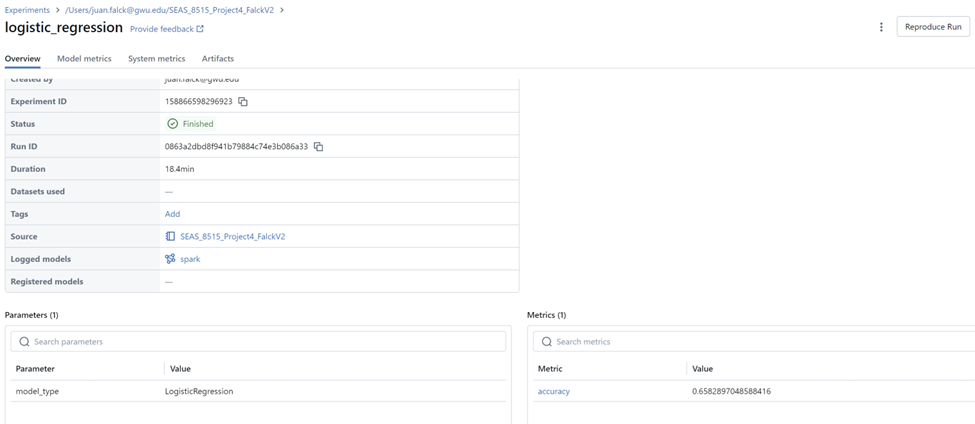

# Model Performance

In [0]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
predictions_pd = predictions_rf.select("target", "prediction").toPandas()


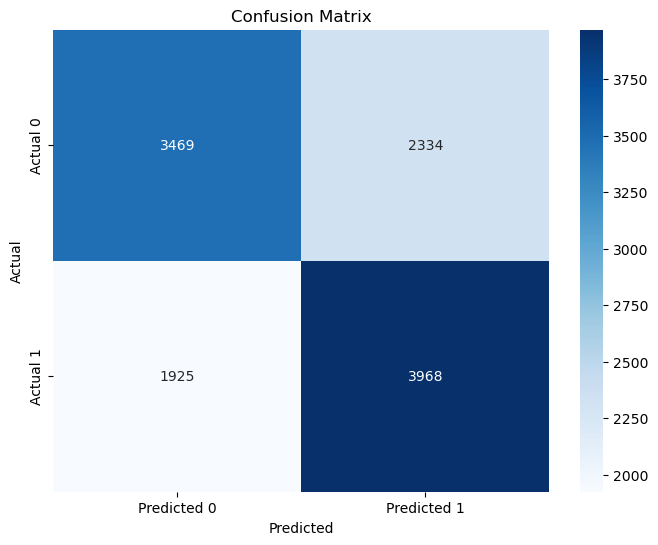

              precision    recall  f1-score   support

           0       0.64      0.60      0.62      5803
           1       0.63      0.67      0.65      5893

    accuracy                           0.64     11696
   macro avg       0.64      0.64      0.64     11696
weighted avg       0.64      0.64      0.64     11696



In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate confusion matrix
conf_matrix = confusion_matrix(predictions_pd["target"], predictions_pd["prediction"])

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(predictions_pd["target"], predictions_pd["prediction"]))


# Question 4 - What are the Most important features for prediction? Do they make sense explaining how the model derives its decision of loan approval?

In [0]:
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# 1. Output the parameters used
best_rf_model = model_rf.bestModel.stages[-1]  # Assuming the RandomForest is the last stage in the pipeline

print("Best Random Forest Model Parameters:")
for param, value in best_rf_model.extractParamMap().items():
    print(f"{param.name}: {value}")

# 2. List the top 20 most important features
# Get feature importances
feature_importances = best_rf_model.featureImportances

# Get feature names from the assembler
assembler = model_rf.bestModel.stages[-2]  # Assuming the VectorAssembler is the second to last stage in the pipeline
feature_names = assembler.getInputCols()

# Create a list of feature importance tuples
feature_importance_list = [(feature_names[i], feature_importances[i]) for i in range(len(feature_names))]

# Sort the list by importance value in descending order and get the top 20 features
top_20_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)[:20]

print("Top 20 Most Important Features:")
for feature, importance in top_20_features:
    print(f"{feature}: {importance}")


Best Random Forest Model Parameters:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: features
impurity: gini
labelCol: target
leafCol: 
maxBins: 32
maxDepth: 10
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 50
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -505740548269256786
subsamplingRate: 1.0
Top 20 Most Important Features:
fico_range_low: 0.16556625613851275
max_bal_bc: 0.10829532513402036
verification_status_index: 0.0819877280596285
dti: 0.08138911523113547
loan_amnt: 0.07396964316736979
inq_last_6mths: 0.0736876673314433
annual_inc: 0.06445524738074412
bc_util: 0.05453169051251062
revol_bal: 0.049174738578519464
revol_util: 0.04840024236723248
open_acc: 0.042759902303969886
total_acc: 0.04056065864765337
mort_acc: 0.031162166391769906
home_ownership_index: 0.02025607701381723
num_accts_ever_120_pd: 0.013989653653405161
tot_coll_am

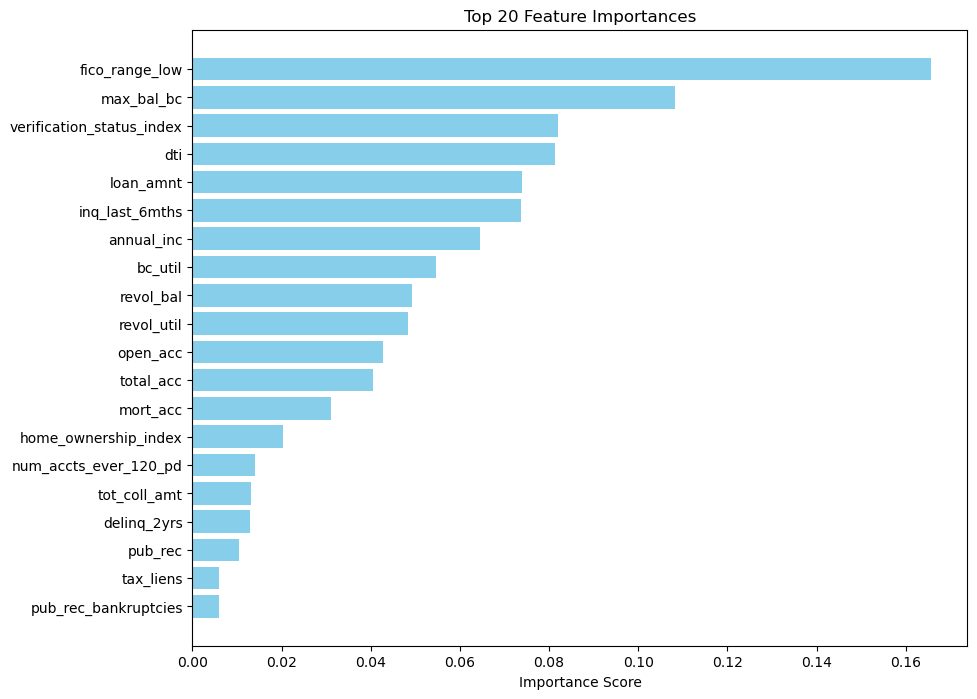

In [0]:
import matplotlib.pyplot as plt

# Assuming top_20_features is already defined
# Example: top_20_features = [('feature1', 0.15), ('feature2', 0.13), ...]

# Extract feature names and their importance scores
features, importance_scores = zip(*top_20_features)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(features, importance_scores, color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


In [0]:
#########################################################################################################
##########################################################################################################

# DONE

In [0]:
#########################################################################################################
#########################################################################################################